is network continuous? =  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


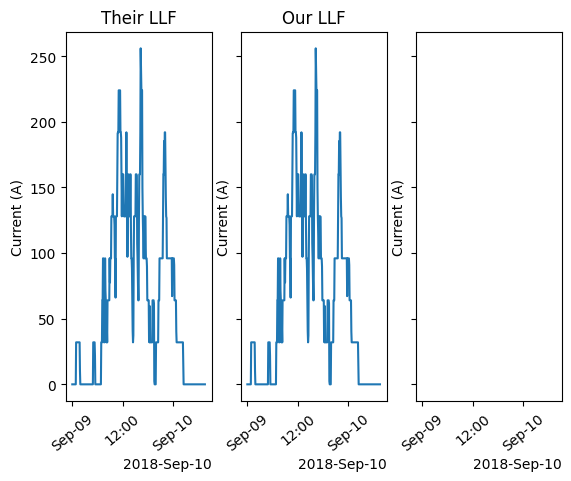

2
2_39_138_29_2018-09-09 17:27:30.494401
aaa
bbb
charging rates [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          

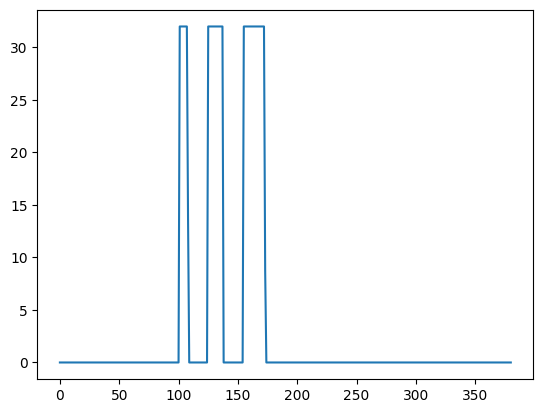

2_39_138_29_2018-09-09 17:27:30.494401
aaa
bbb
charging rates [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.
 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 32. 3

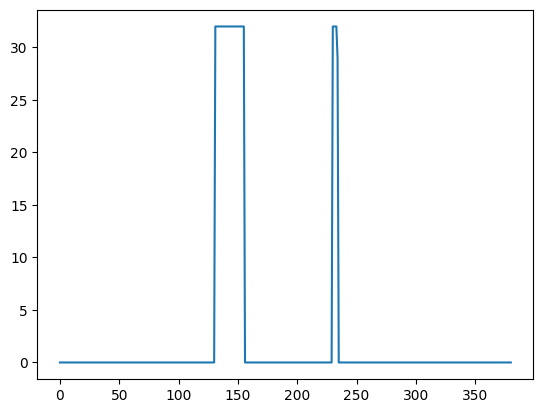

2
2_39_138_29_2018-09-09 17:27:30.494401
aaa
bbb
charging rates [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.
 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 32.

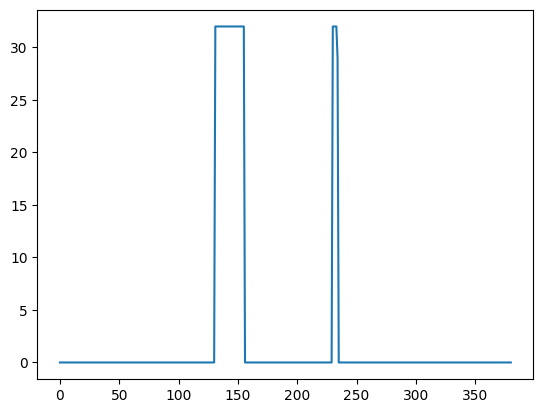

In [1]:
from acnportal.algorithms import BaseAlgorithm, UpperBoundEstimatorBase, infrastructure_constraints_feasible,format_array_schedule
from acnportal.algorithms import (
     enforce_pilot_limit,
     apply_upper_bound_estimate,
     apply_minimum_charging_rate,
     remove_finished_sessions,
 )
import numpy as np
from typing import Callable, List, Optional, Dict
# from upper_bound_estimator import UpperBoundEstimatorBase
# from base_algorithm import BaseAlgorithm
# from utils import infrastructure_constraints_feasible
# from postprocessing import format_array_schedule
# from preprocessing import (
#     enforce_pilot_limit,
#     apply_upper_bound_estimate,
#     apply_minimum_charging_rate,
#     remove_finished_sessions,
# )
from warnings import warn
import copy
from acnportal.acnsim.interface import SessionInfo, InfrastructureInfo, Interface

%run shafei2_testing_laxity.ipynb


In [2]:
def level_1_network(transformer_cap=200, evse_per_phase=34):
    """ Configurable charging network for level-1 EVSEs connected line to ground
        at 120 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=False)
    voltage = 120
    evse_type = 'BASIC'
    # Define the sets of EVSEs in the Caltech ACN.
    A_ids = ['A-{0}'.format(i) for i in range(evse_per_phase)]
    B_ids = ['B-{0}'.format(i) for i in range(evse_per_phase)]
    C_ids = ['C-{0}'.format(i) for i in range(evse_per_phase)]

    # Add Caltech EVSEs
    for evse_id in A_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, 0)
    for evse_id in B_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, 120)
    for evse_id in C_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, -120)

    # Add Caltech Constraint Set
    I3a = acnsim.Current(A_ids)
    I3b = acnsim.Current(B_ids)
    I3c = acnsim.Current(C_ids)

    # Define intermediate currents
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 277
    secondary_side_constr = transformer_cap * 1000 / 3 / 120
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network


def level_2_network(transformer_cap=200, evse_per_phase=34):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 208 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    voltage = 220
    # evse_type = 'AeroVironment'
    evse_type = 'BASIC'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(evse_per_phase)]
    BC_ids = ['BC-{0}'.format(i) for i in range(evse_per_phase)]
    CA_ids = ['CA-{0}'.format(i) for i in range(evse_per_phase)]

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 277
    secondary_side_constr = transformer_cap * 1000 / 3 / 120
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

In [3]:


# -- Experiment Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = timezone.localize(datetime(2018, 9, 9))
end = timezone.localize(datetime(2018, 9, 11))
period = 5  # minute
voltage = 220  # volts
default_battery_power = 32 * voltage / 1000 # kW
site = 'caltech'
signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

# -- Network -----------------------------------------------------------------------------------------------------------
cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=100)
# level_1 = level_1_network(transformer_cap=200, evse_per_phase=34)


# We wont test level 1 network due to slow charging speed what means there are fewer cars per day
# cn = level_2_network(transformer_cap=100, evse_per_phase=34)


print('is network continuous? = ',cn.is_continuous)

# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)



is network continuous? =  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [4]:
class SortedSchedulingAlgo(BaseAlgorithm):
    """ Class for sorting based algorithms like First Come First Served (FCFS) and
    Earliest Deadline First (EDF).

    Implements abstract class BaseAlgorithm.

    For this family of algorithms, active EVs are first sorted by some metric, then
    current is allocated to each EV in order. To allocate current we use a binary
    search approach which allocates each EV the maximum current possible subject to the
    constraints and already allocated allotments.

    The argument sort_fn controlled how the EVs are sorted and thus which sorting based
    algorithm is implemented.

    Args:
        sort_fn (Callable[[List[SessionInfo], Interface], List[SessionInfo]]): Function
            which takes in a list of SessionInfo objects and returns a list of the
            same SessionInfo objects but sorted according to some metric.
    """

    _sort_fn: Callable[[List[SessionInfo], Interface], List[SessionInfo]]
    estimate_max_rate: bool
    max_rate_estimator: Optional[UpperBoundEstimatorBase]
    uninterrupted_charging: bool
    allow_overcharging: bool
    method: str

    def __init__(
        self,
        sort_fn: Callable[[List[SessionInfo], Interface], List[SessionInfo]],
        estimate_max_rate: bool = False,
        max_rate_estimator: Optional[UpperBoundEstimatorBase] = None,
        uninterrupted_charging: bool = False,
        allow_overcharging: bool = False,
        method: str = "bisection"
    ) -> None:
        super().__init__()
        self._sort_fn = sort_fn
        # Call algorithm each period since it only returns a rate for the
        # next period.
        self.max_recompute = 1
        self.estimate_max_rate = estimate_max_rate
        self.max_rate_estimator = max_rate_estimator
        self.uninterrupted_charging = uninterrupted_charging
        self.allow_overcharging = allow_overcharging
        self.method = method

    def register_interface(self, interface: Interface) -> None:
        """ Register interface to the _simulator/physical system.

        This interface is the only connection between the algorithm and what it
            is controlling. Its purpose is to abstract the underlying
            network so that the same algorithms can run on a simulated
            environment or a physical one.

        Args:
            interface (Interface): An interface to the underlying network
                whether simulated or real.

        Returns:
            None
        """
        self._interface = interface
        if self.max_rate_estimator is not None:
            self.max_rate_estimator.register_interface(interface)


    # add option to choose bisection or golden cut method
    @staticmethod
    def max_feasible_rate(
        method: str,
        station_index: int,
        ub: float,
        schedule: np.ndarray,
        infrastructure: InfrastructureInfo,
        eps: float = 0.0001,
        lb: float = 0.0,
    ) -> float:
        """ Return the maximum feasible rate less than ub subject to the environment's
        constraints.

        If schedule contains non-zero elements at the given time, these are
        treated as fixed allocations and this function will include them
        when determining the maximum feasible rate for the given EVSE.

        Args:
            station_index (int): Index for the station in the schedule
                vector.
            ub (float): Upper bound on the charging rate. [A]
            schedule (np.array[Union[float, int]]): Array of charging rates, where each
                row is the charging rates for a specific session.
            infrastructure (InfrastructureInfo): Description of the electrical
                infrastructure.
            eps (float): Accuracy to which the max rate should be calculated.
                (When the binary search is terminated.)
            lb (float): Lower bound on the charging rate [A]

        Returns:
            float: maximum feasible rate less than ub subject to the
                environment's constraints. [A]
        """
        
        def bisection(
            _index: int, _lb: float, _ub: float, _schedule: np.ndarray
        ) -> float:
            
            """ Use the bisection method to find the maximum feasible charging
                rate for the EV. """
            # print('check....bis')
            mid: float = (_ub + _lb) / 2
            _new_schedule = copy.copy(schedule)
            _new_schedule[_index] = mid
            epsilon = 1e-3
            if (_ub - _lb) <= epsilon:
                return _lb
            elif infrastructure_constraints_feasible(_new_schedule, infrastructure):
                return bisection(_index, mid, _ub, _new_schedule)
            else:
                return bisection(_index, _lb, mid, _new_schedule)


        def golden_section(
            _index: int, _lb: float, _ub: float, _schedule: np.ndarray
        ) -> float:
            """ Use the golden section method to find the maximum feasible charging
                rate for the EV. """
            # print('golden section')
            a, b = _lb, _ub
            r = 0.61803
            iterations = 0
            epsilon = 1e-3
            while abs(a - b) > epsilon and iterations < 100:
                x1 = a + (1 - r) * (b - a)
                x2 = b - (1 - r) * (b - a)
                iterations += 1
                _new_schedule = copy.copy(schedule)
                _new_schedule[_index] = (a + b) / 2
                if not infrastructure_constraints_feasible(_new_schedule, infrastructure):
                    b = x2
                else:
                    a = x1
            _new_schedule = copy.copy(schedule)
            _new_schedule[_index] = (a + b) / 2
            if not infrastructure_constraints_feasible(_new_schedule, infrastructure):
                # to speed up algorithm, it is not necessary to approximate value if not found within it iterations
                return a
            return (a + b) / 2

        def dichotomous_search(
            _index: int, _lb: float, _ub: float, _schedule: np.ndarray
        ) -> float:
            """ Use the dichotomous method to find the maximum feasible charging
                rate for the EV. """
            # print('golden section')
            a, b = _lb, _ub
            iterations = 0
            epsilon = 1e-3
            while 2 * epsilon < (b - a)  and iterations < 100:
                x1 = ((a + b) / 2) - epsilon
                x2 = ((a - b) / 2) + epsilon
                iterations += 1
                _new_schedule = copy.copy(schedule)
                _new_schedule[_index] = x1
                if not infrastructure_constraints_feasible(_new_schedule, infrastructure):
                    b = x1
                else:
                    a = x2
            _new_schedule = copy.copy(schedule)
            _new_schedule[_index] = (a + b) / 2
            if not infrastructure_constraints_feasible(_new_schedule, infrastructure):
                # print(f'Wrong result a = {a}, b = {b}')
                # to speed up algorithm, it is not necessary to approximate value if not found within it iterations
                return a
            return (a + b) / 2
            
        def uniform_search(
            _index: int, _lb: float, _ub: float, _schedule: np.ndarray
        ) -> float:
            n = 20 # n >= 3 must hold
            a, b = _lb, _ub
            x0 = a
            xn = b
            epsilon = 1e-3
            iterations = 0
            i = 0
            curr_xi = 0
            while (b - a) > epsilon and iterations < 100:
                x_i_minus_1 = x0 + i * ((b - a) / n)
                x_i = x0 + i * ((b - a) / n)
                curr_xi = x_i
                x_i_plus_1 = x0 + (i + 1) * ((b - a) / n)
                
                _new_schedule = copy.copy(schedule)
                _new_schedule[_index] =  x_i_minus_1

                _new_schedule2 = copy.copy(schedule)
                _new_schedule2[_index] =  x_i_plus_1

                i + 1
                iterations += 1
                if not infrastructure_constraints_feasible(_new_schedule, infrastructure):
                    a, b = _lb, a
                    i = 0
                elif not infrastructure_constraints_feasible(_new_schedule2, infrastructure):
                    a, b = x_i_minus_1, x_i_plus_1
                    i = 0
            
            _new_schedule = copy.copy(schedule)
            _new_schedule[_index] = curr_xi
            if not infrastructure_constraints_feasible(_new_schedule, infrastructure):
                # print(f'Wrong result a = {a}, b = {b}')
                # to speed up algorithm, it is not necessary to approximate value if not found within it iterations
                return a
            return curr_xi
                
            
        
        def secant_method(_index: int, _lb: float, _ub: float, _schedule: np.ndarray
                         ) -> float:
            ...
    
        new_schedule = copy.copy(schedule)
        new_schedule[station_index] = ub
        if infrastructure_constraints_feasible(new_schedule, infrastructure):
            return ub
        if method == "bisection":
            return bisection(station_index, lb, ub, schedule)
        elif method == "golden section":
            return golden_section(station_index, lb, ub, schedule)
        elif method == "dichotomy":
            return dichotomous_search(station_index, lb, ub, schedule)
        elif method == "uniform":
            return uniform_search(station_index, lb, ub, schedule)
        # elif method == "secant":
        #     return secant_method(station_index, lb, ub, schedule)
        return bisection(station_index, lb, ub, schedule)
    def sorting_algorithm(
        self, active_sessions: List[SessionInfo], infrastructure: InfrastructureInfo
    ) -> np.ndarray:
        """ Schedule EVs by first sorting them by sort_fn, then allocating
            them their maximum feasible rate.

        See class documentation for description of the algorithm.

        Args:
            active_sessions (List[SessionInfo]): see BaseAlgorithm
            infrastructure (InfrastructureInfo): Description of the electrical
                infrastructure.

        Returns:
            np.array[Union[float, int]]: Array of charging rates, where each
                row is the charging rates for a specific session.
        """
        queue: List[SessionInfo] = self._sort_fn(active_sessions, self.interface)
        schedule: np.ndarray = np.zeros(infrastructure.num_stations)
        # print('ok')
        # Start each EV at its lower bound
        for session in queue:
            station_index: int = infrastructure.get_station_index(session.station_id)
            lb: float = max(0, session.min_rates[0])
            schedule[station_index] = lb

        if not infrastructure_constraints_feasible(schedule, infrastructure):
            raise ValueError(
                "Charging all sessions at their lower bound is not feasible."
            )

        for session in queue:
            # print('continus infrastracture', infrastructure.is_continuous[station_index])
            station_index = infrastructure.get_station_index(session.station_id)
            ub: float = min(
                session.max_rates[0], self.interface.remaining_amp_periods(session)
            )
            lb: float = max(0, session.min_rates[0])
            
            if infrastructure.is_continuous[station_index]:
                # print('is_continuous: yes')
                charging_rate: float = self.max_feasible_rate(
                    self.method, station_index, ub, schedule, infrastructure, eps=0.01, lb=lb
                )
            else:
                allowable = [
                    a
                    for a in infrastructure.allowable_pilots[station_index]
                    if lb <= a <= ub
                ]

                if len(allowable) == 0:
                    charging_rate = 0
                else:
                    charging_rate = self.discrete_max_feasible_rate(
                        station_index, allowable, schedule, infrastructure
                    )
            schedule[station_index] = charging_rate
        return schedule
    def run_postprocessing(
        self, raw_schedule: np.ndarray, infrastructure: InfrastructureInfo
    ) -> Dict[str, List[float]]:
        """ Run a set of postprocessing functions on the schedule returned by the
        algorithm
    
        Args:
            raw_schedule (np.ndarray): An unprocessed schedule returned by a step of the
                algorithm.
            infrastructure (InfrastructureInfo): Description of the electrical
                infrastructure.
    
        Returns:
            Dict[str, List[float]]: Output schedule in a Simulator-accepted form (see
                BaseAlgorithm.schedule).
    
        """
        return format_array_schedule(raw_schedule, infrastructure)
    @staticmethod
    def discrete_max_feasible_rate(
        station_index: int,
        allowable_pilots: List[float],
        schedule: np.ndarray,
        infrastructure: InfrastructureInfo,
    ) -> float:
        """ Return the maximum feasible allowable rate subject to the
            infrastructure's constraints and the discrete pilot constraints of this
            station.

        If schedule contains non-zero elements at the given time, these are
        treated as fixed allocations and this function will include them
        when determining the maximum feasible rate for the given EVSE.

        Args:
            station_index (int): Index for the station in the schedule
                vector.
            allowable_pilots (List[float]): List of allowable charging rates
                sorted in ascending order.
            schedule (np.array[Union[float, int]]): Array of charging rates, where each
                row is the charging rates for a specific session.
            infrastructure (InfrastructureInfo): Description of the electrical
                infrastructure.

        Returns:
            float: maximum feasible rate less than ub subject to the
                infrastructure's constraints. [A]
        """
        if not infrastructure_constraints_feasible(schedule, infrastructure):
            raise ValueError("The initial schedule is not feasible.")
        new_schedule = copy.copy(schedule)
        feasible_idx = len(allowable_pilots) - 1
        new_schedule[station_index] = allowable_pilots[feasible_idx]
        while not infrastructure_constraints_feasible(new_schedule, infrastructure):
            feasible_idx -= 1
            if feasible_idx < 0:
                new_schedule[station_index] = 0
                break
            else:
                new_schedule[station_index] = allowable_pilots[feasible_idx]
        return new_schedule[station_index]
    def schedule(self, active_sessions: List[SessionInfo]) -> Dict[str, List[float]]:
        """ Schedule EVs by first sorting them by sort_fn, then allocating them their
        maximum feasible rate.

        Implements abstract method schedule from BaseAlgorithm.

        See class documentation for description of the algorithm.

        Args:
            active_sessions (List[SessionInfo]): see BaseAlgorithm

        Returns:
            Dict[str, List[float]]: see BaseAlgorithm
        """
        infrastructure = self.interface.infrastructure_info()
        active_sessions = self.run_preprocessing(active_sessions, infrastructure)
        array_schedule = self.sorting_algorithm(active_sessions, infrastructure)
        return self.run_postprocessing(array_schedule, infrastructure)
    def run_preprocessing(
        self, active_sessions: List[SessionInfo], infrastructure: InfrastructureInfo
    ) -> List[SessionInfo]:
        """ Run a set of preprocessing functions on the active_sessions given to the
        algorithm.

        Args:
            active_sessions (List[SessionInfo]): see BaseAlgorithm
            infrastructure (InfrastructureInfo): Description of the electrical
                infrastructure.

        Returns:
            List[SessionInfo]: A list of processed SessionInfo objects.

        """
        
        active_sessions: List[SessionInfo] = remove_finished_sessions(
            active_sessions, infrastructure, self.interface.period
        )
        active_sessions = enforce_pilot_limit(active_sessions, infrastructure)
        if self.estimate_max_rate:
            active_sessions: List[SessionInfo] = apply_upper_bound_estimate(
                self.max_rate_estimator, active_sessions
            )
        if self.uninterrupted_charging:
            active_sessions: List[SessionInfo] = apply_minimum_charging_rate(
                active_sessions, infrastructure, self.interface.period
            )
        return active_sessions
        
     
    

In [5]:
def least_laxity_first(evs: List[SessionInfo], iface: Interface) -> List[SessionInfo]:
    """ Sort EVs by laxity in increasing order.

    Laxity is a measure of the charging flexibility of an EV. Here we define laxity as:
        LAX_i(t) = (estimated_departure_i - t) - (remaining_demand_i(t) / max_rate_i)

    Args:
        evs (List[SessionInfo]): List of EVs to be sorted.
        iface (Interface): Interface object.

    Returns:
        List[SessionInfo]: List of EVs sorted by laxity in increasing order.
    """

    def laxity(ev: SessionInfo) -> float:
        """ Calculate laxity of the EV.

        Args:
            ev (EV): An EV object.

        Returns:
            float: The laxity of the EV.
        """
        lax = (ev.estimated_departure - iface.current_time) - (
            iface.remaining_amp_periods(ev) / iface.max_pilot_signal(ev.station_id)
        )
        return lax

    return sorted(evs, key=laxity)

In [6]:
labels = []
all_simulations = []
number_of_swaps_per_sim = []
number_of_evs_never_charged_per_sim = []

# cn_lvl2_200kw_30 = level_2_network(transformer_cap=100, evse_per_phase=5)

# TODO: add options for labels for different sort functions
def run_simulator(network, 
                  start,
                  period,
                  sort_function,
                  method, 
                  simulations, 
                  labels, 
                  num_swaps, 
                  num_never_charged):
    alg = SortedSchedulingAlgo(sort_fn=least_laxity_first, method=method)
    sim = acnsim.Simulator(deepcopy(network), alg, deepcopy(events), start,signals=signals, period=period, verbose=False)
    sim.run()

    simulations.append(sim)
    try:
        number_of_swaps_per_sim.append(cn.swaps)
        number_of_evs_never_charged_per_sim.append(cn.never_charged)
    except AttributeError:
        number_of_swaps_per_sim.append(0)
        number_of_evs_never_charged_per_sim.append(0)
    if method == "bisection":
        labels.append(f'LLF using their {method} method')
    else:
        labels.append(f'LLF using our {method} method')
    
    return simulations, number_of_swaps_per_sim, number_of_evs_never_charged_per_sim, labels
    
    

In [7]:
# sch_our_llf_meth = SortedSchedulingAlgo(sort_fn=least_laxity_first, method="bisection")
# sim = acnsim.Simulator(deepcopy(cn), sch_our_llf_meth, deepcopy(events), start,signals=signals, period=period, verbose=False)
# sim.run()
methods = ["bisection", "golden section", "dichotomy", "uniform"]

for method in methods:
    print(method)
    all_simulations, number_of_swaps_per_sim, number_of_evs_never_charged_per_sim, labels = run_simulator(network=cn,
                                                                                                          start=start,
                                                                                                          period=period,
                                                                                                          method=method,
                                                                                                          sort_function=least_laxity_first,
                                                                                                          simulations=all_simulations,
                                                                                                          labels=labels,
                                                                                                          num_swaps=number_of_swaps_per_sim,
                                                                                                          num_never_charged=number_of_evs_never_charged_per_sim)

# all_simulations.append(sim)
# try:
#     number_of_swaps_per_sim.append(cn.swaps)
#     number_of_evs_never_charged_per_sim.append(cn.never_charged)
# except AttributeError:
#     number_of_swaps_per_sim.append(0)
#     number_of_evs_never_charged_per_sim.append(0)

# labels.append('LLF using their bisection')



bisection
golden section
dichotomy
uniform


In [8]:
# rewrite running experiments in better way without redundancy

In [9]:


# sch_their_llf = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
# sim2 = acnsim.Simulator(deepcopy(cn), sch_their_llf, deepcopy(events), start,signals=signals, period=period, verbose=False)
# sim2.run()

# all_simulations.append(sim2)
# # number_of_swaps_per_sim.append(cn.swaps)
# # number_of_evs_never_charged_per_sim.append(cn.never_charged)
# labels.append('Their Bisection with LLF')

In [10]:
# sch_our_llf_meth2 = SortedSchedulingAlgo(sort_fn=least_laxity_first, method="golden section")
# sim3 = acnsim.Simulator(deepcopy(cn), sch_our_llf_meth2, deepcopy(events), start,signals=signals, period=period, verbose=False)
# sim3.run()

# all_simulations.append(sim3)
# # number_of_swaps_per_sim.append(cn.swaps)
# # number_of_evs_never_charged_per_sim.append(cn.never_charged)
# # labels.append('Our Golden section with LLF')
# labels.append('LLF using our golden section method')


In [11]:
# sch_our_llf_meth3 = SortedSchedulingAlgo(sort_fn=least_laxity_first, method="dichotomy")
# sim4 = acnsim.Simulator(deepcopy(cn), sch_our_llf_meth3, deepcopy(events), start,signals=signals, period=period, verbose=False)
# sim4.run()

# all_simulations.append(sim4)
# # number_of_swaps_per_sim.append(cn.swaps)
# # number_of_evs_never_charged_per_sim.append(cn.never_charged)
# # labels.append('Our Golden section with LLF')
# labels.append('LLF using our dichotomy method')

In [12]:
# sch_our_llf_meth4 = SortedSchedulingAlgo(sort_fn=least_laxity_first, method="uniform")
# sim4 = acnsim.Simulator(deepcopy(cn), sch_our_llf_meth4, deepcopy(events), start,signals=signals, period=period, verbose=False)
# sim4.run()

# all_simulations.append(sim4)
# # number_of_swaps_per_sim.append(cn.swaps)
# # number_of_evs_never_charged_per_sim.append(cn.never_charged)
# # labels.append('Our Golden section with LLF')
# labels.append('LLF using our uniform method')

In [13]:
import pandas as pd
!pip install dataframe_image --quiet
import dataframe_image as dfi

# Data pro tabulku
data = {
    'Simulation name': [],
    'Proportion of energy delivered': [],
    'Energy costs':[],
    'Energy delivered':[],
    # 'Number of evs never charged':[],
    # 'Number of swaps':[]
}

for i, simulation in enumerate(all_simulations):
    data['Simulation name'].append(labels[i])
    data['Proportion of energy delivered'].append( acnsim.proportion_of_energy_delivered(simulation))
    data['Energy delivered'].append(sum(ev.energy_delivered for ev in all_simulations[i].ev_history.values()))
    data['Energy costs'].append(acnsim.energy_cost(all_simulations[i]))
    # data['Number of evs never charged'].append(number_of_evs_never_charged_per_sim[i])
    # data['Number of swaps'].append(number_of_swaps_per_sim[i])

# Vytvoření DataFrame
df = pd.DataFrame(data)

# Vytisknutí tabulky


dfi.export(df,'experiment2_comparison.png')



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
df
# check if they should have exactly same performance or not
# dichotomous method converges slower than golden section method, so results are a bit worse need to find source of that claim

,Simulation name,Proportion of energy delivered,Energy costs,Energy delivered
0,LLF using their bisection method,0.822549,123.140109,963.686640
1,LLF using our golden section method,0.822549,123.140013,963.686262
2,LLF using our dichotomy method,0.796340,113.656790,932.979617
3,LLF using our uniform method,0.796333,113.655592,932.971333
